<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/12.%20Non%20supervised%20learning%20II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning and Probabilistic Models

The Bayes rule for a given input is:

$$ 
p(y \vert x) = \frac{p(x \vert y) p(y)}{p(x)} = \frac{p(x,y)}{p(x)}
$$

Discriminative classifiers jump directly to estimating $p(y \vert x)$ without modeling its component parts $p(x,y)$ and $p(x)$.

The objective of *generative models* is to learn a model $p(x)$. This model can be used for several purposes, but we are specially interested in models we can sample from. 

To this end we have several possible strategies when considering deep learning tools:

+ **Fully-observed models.** To model observed data directly, without introducing any new unobserved local variables.

+ **Transformation models.** Model data as a transformation of an unobserved noise source using a *parameterised* function.

+ **Latent-variable models.** Introduce unobserved random variables for every observed data point to explain hidden causes.

### Fully-observed models.

The most succesful models are PixelCNN (https://arxiv.org/pdf/1606.05328v2.pdf) and WaveNet (https://arxiv.org/pdf/1609.03499.pdf)).

Both cases are based on autoregressive models that models the conditional distribution of every individual data feature (pixels,etc.) given previous features:

$$
p(\mathbf x) = \prod_{i=1}^{N} p(x_i \vert x_1, \dots ,x_{i-1})
$$

All conditional probabilities are described by deep networks.

Its advantages are:

+ Parameter learning is simple: Log-likelihood is directly computable, no approximation needed.
+ Easy to scale-up to large models, many optimisation tools available.

But generation can be slow: we must iterate through all elements sequentially!

### Transformation Models

Transformation models model $p(x,z)$ instead of $p(x)$, where $z$ is an unobserved noise source. 

In the simplest case, they transform an unobserved noise source $z \sim \mathcal{N}(0,I)$ using a parameterised function. The transformation function is parameterised by a linear or deep network $f_\lambda(z)$. 

For example, for producing $x \sim \mathcal{N}(\mu, \Sigma)$ we can sample $z \sim \mathcal{N}(0,I)$ and then apply $x = \mu + \Sigma z$.

The main drawbacks of this strategy are the difficulty to extend to generic data types and the difficulty to account for noise in observed data.

### Latent variable models 

Latent variable models solve this problems by introducing unobserved
local random variables that represents *hidden causes* and which can be easily sampled. 

Variational autoencoders are a good example of this strategy that propose a specific probability model of data $x$ and latent variables $z$. 

## Autoregressive Models (fully observed models).

By the chain rule of probability, we can factorize the joint distribution over the $n$-dimensions as

$$
p(x)=∏_{i=1}^np(x_i|x_1,x_2,…,x_{i−1})=∏_{i=1}^n p(x_i|x_{<i})
$$


where $x_{<i}=[x_1,x_2,…,x_{i−1}]$ denotes the vector of random variables with index less than $i$. In most of the cases, variables can be sorted in an arbitrary way.

The term autoregressive originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. In this case, variable must be sorted by time.

In an autoregressive generative model, the conditionals are specified as **parameterized functions with a fixed number of parameters**. 

### Naive approximation

In the simplest case (binay data), we can specify the function that represents conditionals as a linear combination of the input elements followed by a sigmoid non-linearity (to restrict the output to lie between 0 and 1). 

This gives us the formulation of a **fully-visible sigmoid belief network** (FVSBN):

$$
f_i(x_1,x_2,…,x_{i−1})=σ(α^{(i)}_0+α^{(i)}_1x_1+…+α^{(i)}_{i−1}x_{i−1})
$$

<center>
<img src="https://deepgenerativemodels.github.io/notes/autoregressive/fvsbn.png" alt="" style="width: 100px;"/> 
(Source: https://deepgenerativemodels.github.io/notes/autoregressive/)
</center>

The conditional for variable $i$ requires $i$ parameters, and hence the total number of parameters in the model is given by $\sum_{i=1}^{n} i = O(n^2)$. This is a large number of parameters!

A natural way to increase the expressiveness of an autoregressive generative model is to use more flexible parameterizations 
e.g., multi-layer perceptrons (MLP). 

For example, consider the case of a neural network with 1 hidden layer. The  function for variable $i$ can be expressed as:
$$
h_i=σ(A_i x_{<i}+c_i)
$$

$$
f_i(x_1,x_2,…,x_{i−1})=σ(α^{(i)}h_i+b_i)
$$

where $h_i \in \Re^d$ denotes the hidden layer activations for the MLP.

The total number of parameters in this model is dominated by the matrices $A_i$ and given by $O(n^2d)$.

### Neural Autoregressive Density Estimator

The *Neural Autoregressive Density Estimator* (NADE) provides an alternate MLP-based parameterization that is more statistically and computationally efficient than the vanilla approach. In NADE, parameters are shared across the functions used for evaluating the conditionals. In particular, the hidden layer activations are specified as

$$
h_i=σ(W_{:,{<i}} x_{<i}+c)
$$

$$
f_i(x_1,x_2,…,x_{i−1})=σ(V_{i,:}h_i+b_i)
$$

where $W, V, b, c$ are learnable parameters of the model. 

<center>
<img src="https://deepgenerativemodels.github.io/notes/autoregressive/nade.png" alt="" style="width: 100px;"/> 
(Source: https://deepgenerativemodels.github.io/notes/autoregressive/)
</center>

The weight matrix $W$ and the bias vector $c$ are shared across the conditionals: the total number of parameters gets reduced from $O(n^2d)$ to $O(nd)$.


### PixelCNN

Autoregressive models can be extended to image data. 

See, for example, **PixelCNN**. https://towardsdatascience.com/auto-regressive-generative-models-pixelrnn-pixelcnn-32d192911173



## GAN: Generative Adversarial Networks

GAN are an alternative to model $p(x)$.

The basic idea of GANs is to set up a game between two players. 

One of them is
called the **generator**. The generator creates samples that are intended to come
from the same distribution as the training data. 

The other player is the **discriminator**.
The discriminator examines samples to determine whether they are real or fake. 

The discriminator learns using traditional supervised learning
techniques, dividing inputs into two classes (real or fake). The generator
is trained to fool the discriminator.

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/gan1.png?raw=1" alt="" style="width: 500px;"/> 
(Source: https://arxiv.org/pdf/1701.00160.pdf)
</center>

The two players in the game are represented by two functions, each of which
is differentiable both with respect to its inputs and with respect to its parameters.

The discriminator is a function $D$ that takes $x_{real}$ and $x_{fake}$ as input and uses $\theta^D$ as parameters. 

The generator is defined by a function $G$ that takes $z$ as input and uses $\theta^G$ as parameters.

Both players have cost functions that are defined in terms of both players’ parameters. 

The discriminator wishes to minimize $J^D = (\theta^D, \theta^G)$ and
must do so while controlling only $\theta^D$.

The generator wishes to minimize $J^G = (\theta^D, \theta^G)$
and must do so while controlling only $\theta^G$. 

Because each
player’s cost depends on the other player’s parameters, but each player cannot
control the other player’s parameters, this scenario is most straightforward to
describe as a game rather than as an optimization problem. 

The solution to an
optimization problem is a (local) minimum, a point in parameter space where all
neighboring points have greater or equal cost. The solution to a game is a Nash
equilibrium. In this context, a Nash equilibrium is a tuple $(\theta^D, \theta^G)$
that is a local minimum of $J^D$ with respect to $\theta^D$ and a local minimum of
$J^G$ with respect to $\theta^G$.

### The generator

The generator is simply a differentiable function $G$. When
$z$ is sampled from some simple prior distribution, $G(z)$ yields a sample of $x$. Typically, a deep neural network is used to represent $G$.

### The training process

The training process consists of simultaneous SGD. 
On each step, two minibatches are sampled: a minibatch of $x$ values from the
dataset and a minibatch of $z$ values drawn from the model’s prior over latent
variables. Then two gradient steps are made simultaneously: one updating $\theta^D$
to reduce $J^D$ and one updating $\theta^G$ to reduce $J^G$.

In both cases, it is possible to use the gradient-based optimization algorithm of your choice. Adam is usually a good choice. 

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/t12.png?raw=1" alt="" style="width: 600px;"/> 
</center>

###  The discriminator’s cost

The cost used for the discriminator is:

$$
J^D = - \frac{1}{2} \mathop{{}\mathbb{E}}_x \mathop{{}log} D(x) - \frac{1}{2} \mathop{{}\mathbb{E}}_z \mathop{{}log} (1 - D(G(z)))
$$

This is just the standard cross-entropy cost that is minimized when training
a standard binary classifier with a sigmoid output. The only difference is that
the classifier is trained on two minibatches of data; one coming from the dataset,
where the label is 1 for all examples, and one coming from the generator, where
the label is 0 for all examples.

###  The generator’s cost

The simplest version of the game is a zero-sum game, in which the sum of
all player’s costs is always zero. In this version of the game:

$$
J^G = - J^D
$$


## Example

Training a generative adversarial network to sample from a Gaussian distribution. 
(Adapted from: http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html)

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

This will be our target distribution:

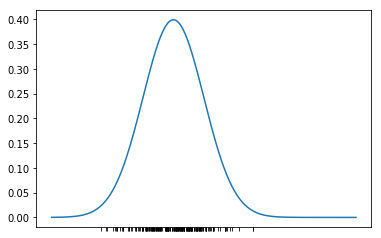

In [3]:
# target distribution
import warnings
warnings.filterwarnings("ignore")

mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))
r = norm.rvs(-1,1,size=200)

ax = plt.axes()
ax.xaxis.set_major_formatter(plt.NullFormatter())
b = plt.xticks(r)

The horizontal axis represents the domain of $x$. The generator network will map random values to this domain. 

Our discriminator and generator networks will be MLP:

In [0]:
TRAIN_ITERS=20000
M=200 # minibatch size

def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [0]:
TRAIN_ITERS=20000
M=200 # minibatch size

def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.relu(tf.matmul(input,w1)+b1)
    fc2=tf.nn.relu(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [0]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,               # Base learning rate.
        batch,               # Current index into the dataset.
        TRAIN_ITERS // 4,    # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,
                                                                     global_step=batch,
                                                                     var_list=var_list)
    return optimizer

Pre-train discriminator

Instructions for updating:
Colocations handled automatically by placer.


Text(0.5, 1.0, 'Initial Decision Boundary')

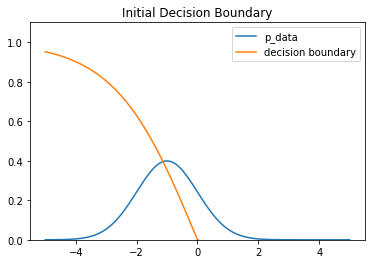

In [6]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D - train_labels))
    
optimizer=momentum_optimizer(loss,None)

sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    
    # process multiple points in parallel in a minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})
    
    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()
    
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')

In [0]:
lh=np.zeros(1000)
for i in range(1000):
    d=(np.random.random(M)-0.5) * 10.0 
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], 
                     {input_node: np.reshape(d,(M,1)), 
                      train_labels: np.reshape(labels,(M,1))})

Text(0.5, 1.0, 'Training Loss')

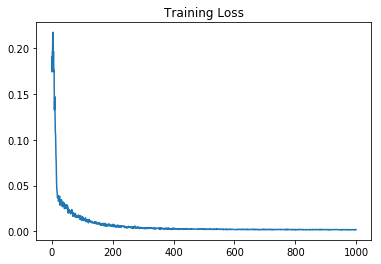

In [8]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

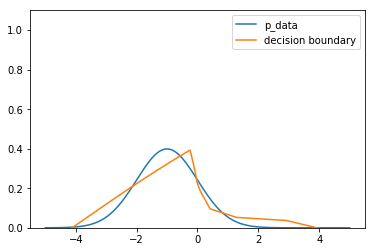

In [9]:
plot_d0(D,input_node)

In [0]:
# copy the learned weights over into a tmp array
weightsD=sess.run(theta)

# close the pre-training session
sess.close()

Now to build the actual generative adversarial network


In [0]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) # M uniform01 floats
    G,theta_g=mlp(z_node,1) # generate normal transformation of Z
    G=tf.multiply(5.0,G) # scale up by 5 to match range

with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1)) # input M normally distributed floats
    fc,theta_d=mlp(x_node,1) # output likelihood of being normally distributed
    D1=tf.maximum(tf.minimum(fc,.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)

obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))

# set up optimizer for G,D
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

In [0]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [0]:
# copy weights from pre-training over to new D network
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))


Text(0.5, 1.0, 'Before Training')

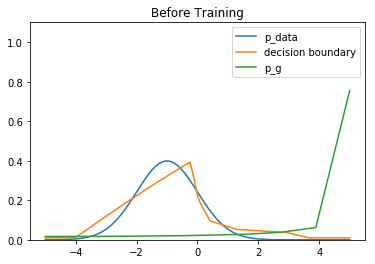

In [14]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(int(r/M)):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()
    
# initial conditions
plot_fig()
plt.title('Before Training')

In [15]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], 
                            {x_node: np.reshape(x,(M,1)), 
                             z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], 
                        {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


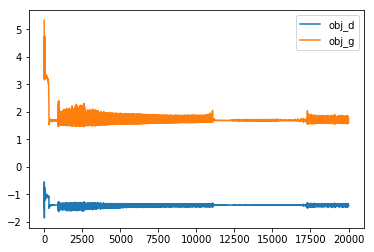

In [16]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

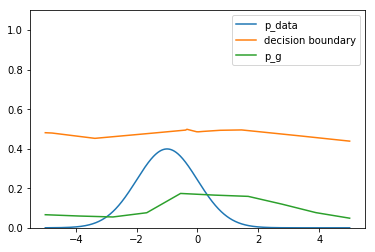

In [17]:
plot_fig()

### DGAN Architecture

Most GANs today are at least loosely based on the DCGAN architecture (Radford
et al., 2015). DCGAN stands for “deep, convolution GAN.”

Some of the key insights of the DCGAN architecture were to:

+ Use batch normalization layers in most layers
of both the discriminator and the generator, with the two minibatches for
the discriminator normalized separately. 

+ The overall network structure is mostly borrowed from the all-convolutional
net. 

+ The use of the Adam optimizer rather than SGD with momentum. 

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/dgan.png?raw=1" alt="" style="width: 700px;"/> 
(Source: https://arxiv.org/pdf/1511.06434.pdf)
</center>


Generated bedrooms after one training pass through the dataset: 


<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/dgan2.png?raw=1" alt="" style="width: 700px;"/> 
(Source: https://github.com/Newmu/dcgan_code)
</center>


Covers: 

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/dgan3.png?raw=1" alt="" style="width: 700px;"/> 
(Source: https://github.com/Newmu/dcgan_code)
</center>



## MNIST GAN



In [0]:
# Keras imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

# We'll be downloading and reading in the MNIST data from Tensorflow
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
import keras.backend.tensorflow_backend as ktf
import tensorflow as tf
import os

def get_session(gpu_fraction=0.45):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

Using TensorFlow backend.


In [0]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

In [0]:
net_discriminator = discriminator()
net_discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
___________________________

In [0]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4

    net.add(Dense(7*7*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

In [0]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       819328    
__________

In [0]:
dis_lr=0.0008
dis_clipvalue=1.0
dis_decay=1e-10
dis_optimizer = RMSprop

optim_discriminator = RMSprop(lr=dis_lr, clipvalue=dis_clipvalue, decay=dis_decay)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

model_discriminator.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [0]:
adv_lr=0.0004
adv_clipvalue=1.0
adv_decay=1e-10
adv_optimizer = Adam

optim_adversarial = Adam(lr=adv_lr, clipvalue=adv_clipvalue, decay=adv_decay)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])
model_adversarial.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

FileNotFoundError: ignored

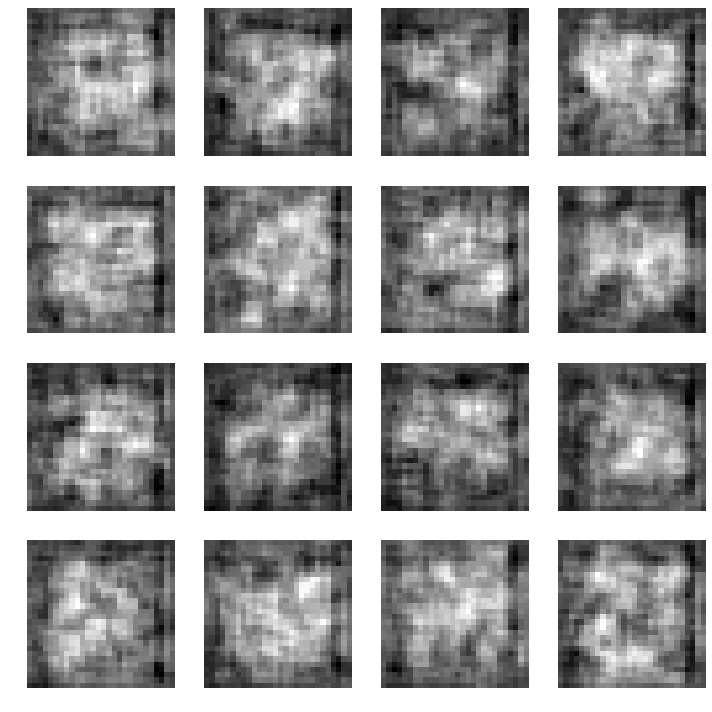

In [0]:
# Read MNIST data
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

# Map the images to a new range [-1, 1]
#x_train = x_train / 0.5 - 1

import os
os.makedirs("output/mnist-normal2")

batch_size = 256

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(10001):
    
    # Select a random set of training images from the mnist dataset
    images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
    # Generate a random noise vector
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    # Use the generator to create fake images from the noise vector
    images_fake = net_generator.predict(noise)
    
    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    # Train the generator
    # The input of the adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated images as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
           
    if i % 500 == 0:
        # Visualize the performance of the generator by producing images from the test vector
        images = net_generator.predict(vis_noise)
        # Map back to original range
        #images = (images + 1 ) * 0.5
        plt.figure(figsize=(10,10))
        
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])
            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(r'output/mnist-normal/{}.png'.format(i))
        plt.close('all')

In [0]:
# create a gif from the  generator's saved output (in that output/mnist-normal directory)

import imageio

filenames = [r'output/mnist-normal/{}.png'.format(i * 500) for i in range(20)]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'output/mnist-normal/learning.gif', images, duration=0.5)

Image(url='output/mnist-normal/learning.gif')  

plt.figure(figsize=(15,4))

for i in range(10):
    noise = np.zeros([1,100]) - 1 + (i * 0.2)
    images = net_generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.savefig(r'output/mnist-normal/morph_example.png'.format(i))
experiment.log_image(r'output/mnist-normal/morph_example.png'.format(i))
plt.show()

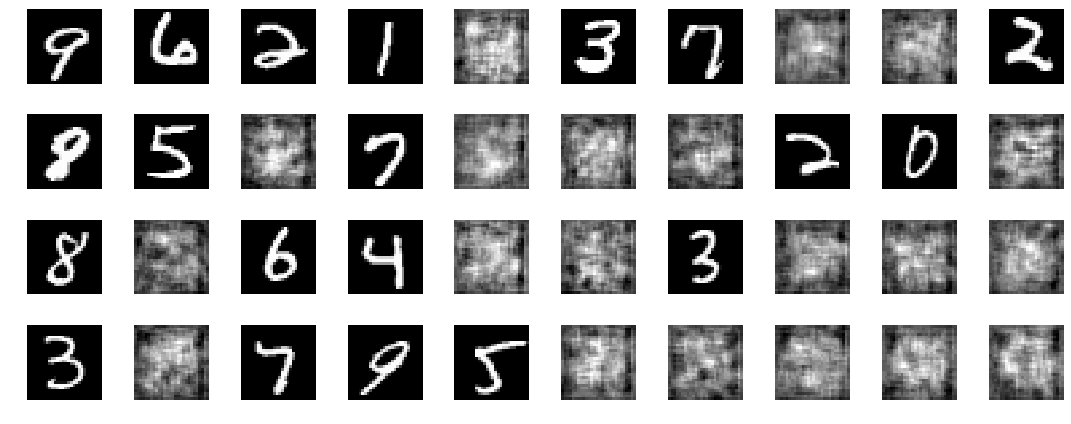

FileNotFoundError: ignored

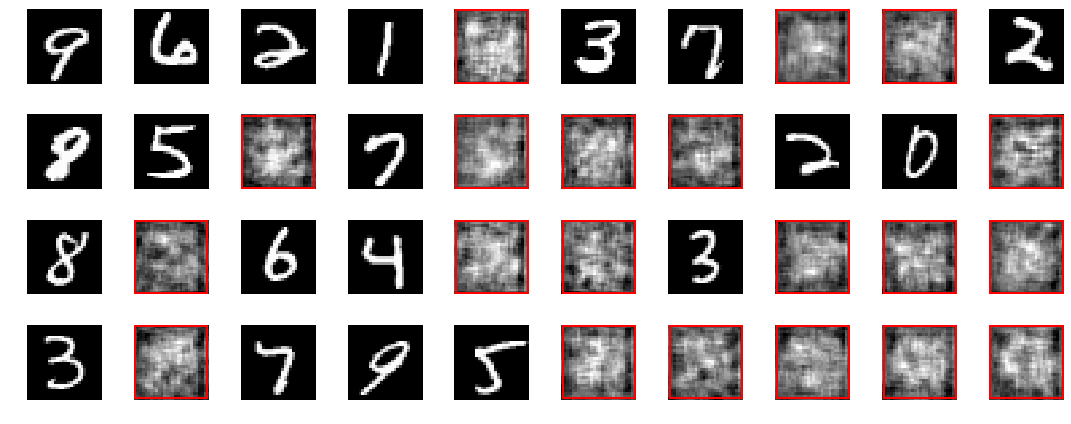

In [0]:
import matplotlib.patches as plot_patch

plt.figure(figsize=(15,6))
noise = np.random.uniform(-1.0, 1.0, size=[40, 100])
images_fake = net_generator.predict(noise)
images_real = x_train[np.random.randint(0, x_train.shape[0], size=40), :, :, :]
choice_vector = np.random.uniform(0, 1, size=40)

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [28, 28])

    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))

border = np.zeros((28,28,3))
border[0,:] = [255,0,0]
border[:,0] = [255,0,0]

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [28, 28])
    
    ax = plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    if choice_vector[i] > 0.5:
        ax.add_patch(plot_patch.Rectangle((0,0), 27, 27, edgecolor="red", linewidth=2, fill=False))   
    plt.axis('off')

plt.tight_layout()
plt.savefig(r'output/mnist-normal/final_results_sample.png'.format(i))
experiment.log_image(r'output/mnist-normal/final_results_sample.png'.format(i))
plt.show()

https://www.youtube.com/watch?v=kSLJriaOumA&feature=youtu.be

https://poloclub.github.io/ganlab/